In [27]:
from pathlib import Path
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import utils
from metadata import ImageDataset, patient
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [28]:
notebooks_path = Path.cwd()
repo_path = notebooks_path.parent
print(f'The current directory is: {notebooks_path}')

The current directory is: /home/ricardino/Documents/MAIA/tercer_semestre/MISA/final_project/MISA_FINAL_PROJECT/notebooks


# Functions

In [11]:
def extract_pixels(im_list:list, mask:np.ndarray):
    """extract pixels from a list of images based on a mask

    Args:
        im_list (list): list of images
        mask (np.ndarray): mask to extract the pixels

    Returns:
        np.ndarray: extracted pixels flattened
    """
    ims_flat = [x[mask!=0] for x in im_list]
    extracted = np.stack(ims_flat).T
    extracted = extracted.reshape(extracted.shape[0], -1)
    
    return extracted

def reindexing(alphas:np.ndarray, means:list, covs:list):
    """Reindexing function designed to avoid the probelm of the order of tissue ordering after kmeans initialization

    Args:
        alphas (np.ndarray): alpha values
        means (list): list of means
        covs (list): list of covariances

    Returns:
        same as input: same three inputs but reordered
    """

    means_np = np.vstack(means) #turn means into numpy array
    covs_np = np.vstack(covs) #turn covs into numpy array
    idx = np.argsort(means_np[:,0]) #get indexing for sorting
    means_np = means_np[idx] #reorder
    covs_np = covs_np[idx] #reorder
    alphas = alphas[idx] #reorder
    means = [means_np[i] for i in range(3)] #restore
    covs = [covs_np[i] for i in range(3)] #restore
    
    return alphas, means, covs

def init_kmeans(extracted:np.ndarray, n_components=3):
    """performs kmenas to extracted pixles

    Args:
        extracted (array): extracted pixels
        n_components (in): number of components

    Returns:
        array, list, list: alphas, means and covariances
    """
    kmeans = KMeans(n_clusters=n_components) #3 tissue types
    labels = kmeans.fit_predict(extracted) #predict labels
    centers = kmeans.cluster_centers_ #predict centers
    alphas = np.ones(n_components)/n_components #init alphas
    
    for i, cluster in enumerate(np.unique(labels)):
        alphas[i] = np.sum(labels==cluster)/labels.shape[0] #update alphas
    
    means = []
    covs = []
    
    for cluster in range(n_components):
        means.append(centers[cluster])
        covs.append(np.cov(extracted[labels==cluster].T))
        
    return reindexing(alphas, means, covs)

def E_step(extracted, n_components, alphas, means, covs):
    """expectation step of em algorithm

    Args:
        extracted (array): pixels to be used for the intensity model
        n_components (int): number of clusters
        alphas (array): alphas of the EM model
        means (array): means fo the clusters
        covs (array): covariance matrix of the clusters

    Returns:
        arrays: pk and wk according to the EM algorithm
    """
    pk = np.zeros((extracted.shape[0], n_components))
    for cluster in range(n_components):
        pk[:,cluster] = alphas[cluster] * multivariate_normal.pdf(extracted, mean=means[cluster], cov=covs[cluster]) #weigted pk calculation
    wk = np.zeros((extracted.shape[0], n_components))
    for cluster in range(n_components):
        wk[:,cluster] = pk[:,cluster]/np.sum(pk, axis=1) #wk calculation
    
    return pk, wk

def M_step(wk, n_components, extracted, means, covs):
    """maximisation step of em algorithm

    Args:
        wk (array): wk value as descibed in the EM algorithm
        n_components (int): number of components in clustering
        extracted (array): extracted pixels
        means (list): list of means
        covs (list): list of covariances

    Returns:
        array, list and list: parameters of EM algorithm
    """
    nk = np.sum(wk, axis=0) #nk calculation
    alphas = nk/wk.shape[0] #alphas calculation
    for cluster in range(n_components):
        means[cluster] = np.sum(wk[:,cluster][:,np.newaxis] * extracted, axis=0)/nk[cluster]
    for cluster in range(n_components):
        covs[cluster] = (wk[:,cluster][:,np.newaxis]*(extracted-means[cluster])).T @ (extracted-means[cluster])/nk[cluster]
    return alphas, means, covs

def log_likehood(pk):
    """returns log likehood of the model

    Args:
        pk (array): pk as descibed in the EM algorithm

    Returns:
        float: value of the log likehood
    """
    return np.log(pk.sum(axis=1)).sum()

def ll_diff(pk, prev_log, new_log):
    """difference between log likehoods

    Args:
        pk (array): pk as descibed in the EM algorithm
        prev_log (float): previous log likehood
        new_log (float): new log likehood

    Returns:
        float: absolute difference between log likehoods
    """
    prev_log = new_log
    new_log = log_likehood(pk)
    return abs(new_log - prev_log), prev_log, new_log

def get_seg(im_list, wk, mask):
    """given wk returns final segmentation

    Args:
        wk (array): wk array of EM algorithm
    """
    labels = np.argmax(wk, axis=1) + 1 #get labels
    seg_mask = np.zeros(im_list[0].shape) #create empy mask
    seg_mask[mask!=0] = labels #assign pixels to empy maskEl c'odigo
    
    return seg_mask

In [12]:
def init_segmentation(im_list:list, id:str, seg_name:str, n_tissue=3):
    """initial segemntation coming from previously obtained segmentations

    Args:
        im_list (list): images of the patient
        id (str): id of the patient (same as in the dataset)
        seg_name (str): name of the segmentation used
        n_tissue (int, optional): number of tissues. Defaults to 3.

    Returns:
        np.ndarray, list, list: alphas, means and covariances
    """
    #get segmentation
    seg = utils.getArrayfromPath(str(repo_path / 'data'/'segmentations'/f'{seg_name}_{id}_seg.nii.gz'))
    #get image
    im = im_list[0]
    #init means and covariances
    means = []
    covs = []
    for i in range(1,n_tissue+1):
        extracted = np.extract(seg==i, im) #extract pixels of each tissue
        means.append(extracted.mean()) #append mean
        covs.append(np.cov(extracted.T)) #append covariance
        
    #initialize alphas
    alphas = np.ones(n_tissue)/n_tissue #evenly distributed
    n = np.extract(seg!=0, im).shape[0] #number of pixels
    for i in range(1,n_tissue+1):
        alphas[i-1] = np.sum(seg==i)/n #update alphas
        
    return alphas, means, covs

In [13]:
def EM(im_list:list, mask:np.ndarray, init_method:str):
    """EM algorithm

    Args:
        im_list (list): list of images to be used (of the same patient)
        mask (np.ndarray): attention mask where pixels will be extracted
        init_method (str): initialisation method

    Returns:
        np.ndarray, list: segmentation and list with log likehoods differences
    """

    #first we extract the pixels under the mask
    extracted = extract_pixels(im_list, mask)

    #select initalisation method
    if init_method == 'kmeans':
        alphas, means, covs = init_kmeans(extracted, n_components=3)

    #Stopping criteria
    prev_log = 0
    new_log = 2
    error = 10e-6
    iter_num = 500    

    #store diff in list
    diff_list = []
    #start loop
    for i in range(iter_num):
        #EM step
        pk, wk = E_step(extracted, n_components=3, alphas=alphas, means=means, covs=covs)
        #M step
        alphas, means, covs = M_step(wk, n_components=3, extracted=extracted, means=means, covs=covs)
        #ll calculation
        diff, prev_log, new_log = ll_diff(pk, prev_log, new_log)
        #store diff in list
        diff_list.append(diff)
        if diff < error: #check if error is small enough
            break

    #final segmentation
    seg_mask = get_seg(im_list, wk, mask)
    
    return seg_mask, diff_list

# MAIN

We are going to apply the EM algorithm on the validaiton images

In [14]:
# im_data_val = ImageDataset(set_name='Validation')
# #EM initialisation method
# init_method = 'kmeans'
# #empy df to store results
# df_EM = None

# #LOOP starts here
# for id_val in tqdm(im_data_val.IDs):
#     #define pat
#     pat_val = patient(id_val, im_data_val)
#     #define list of images
#     im_list = [pat_val.im(format='np', preprocess=False)]
#     #define mask using all pixels in the image that are not zero
#     mask = im_list[0]>0

#     #first we extract the pixels under the mask
#     extracted = extract_pixels(im_list, mask)

#     #select initalisation method
#     if init_method == 'kmeans':
#         alphas, means, covs = init_kmeans(extracted)
#     else:
#         alphas, means, covs = init_segmentation(im_list, id_val, seg_name=init_method)

#     #Stopping criteria
#     prev_log = 0
#     new_log = 2
#     error = 10e-6
#     iter_num = 500    

#     #store diff in list
#     diff_list = []
#     #start loop
#     for i in range(iter_num):
#         #EM step
#         pk, wk = E_step(extracted, n_components=3, alphas=alphas, means=means, covs=covs)
#         #M step
#         alphas, means, covs = M_step(wk, n_components=3, extracted=extracted, means=means, covs=covs)
#         #ll calculation
#         diff, prev_log, new_log = ll_diff(pk, prev_log, new_log)
#         #store diff in list
#         diff_list.append(diff)
#         if diff < error: #check if error is small enough
#             break

#     #final segmentation
#     seg_mask = get_seg(im_list, wk, mask)

#     #compute metrics
#     df_metrics = utils.compute_metrics(seg_mask, pat_val, id_val)
#     #concatenate in df_maxM
#     df_EM = pd.concat([df_EM, df_metrics], axis=0)
# #save the dataframe
# df_EM.to_csv(repo_path / 'data'/'results'/f'EM_{init_method}_metrics.csv', index=False)

# EM into and after
- Now we can use the probabilistic atlas into and after the EM algorithm
The probabilistic atlas could be:
    - Top atlases probabilities
    - Bayesian atlases probabilities

In [15]:
def extracted_atlas(atlas_prob, mask):
    """extract atlas pixels ot be able to use them in the EM algorithm

    Args:
        atlas_prob (4D array): volumnes of atlas probabilities
        mask (array): mask for skull stripping

    Returns:
        array: faltten atlas probabilities
    """
    extracted_atlas_csf = extract_pixels([atlas_prob[0]], mask)
    extracted_atlas_wm = extract_pixels([atlas_prob[1]], mask)
    extracted_atlas_gm = extract_pixels([atlas_prob[2]], mask)
    
    return np.array([extracted_atlas_csf, extracted_atlas_wm, extracted_atlas_gm]).T[0]

def atlas_punishment(wk, extracted_atlas, n_components=3):
    for i in range(n_components):
        wk[:,i] = wk[:,i]*extracted_atlas[:,i]
    return wk

In [40]:
im_data_val = ImageDataset(set_name='Validation')
#EM initialisation method
init_method = 'bayesian'
#EM mod
mod = 'after'
#empy df to store results
df_EM = None

#LOOP starts here
for id_val in tqdm(im_data_val.IDs):
    #define pat
    pat_val = patient(id_val, im_data_val)
    #define list of images
    im_list = [pat_val.im(format='np', preprocess=True)]
    #define mask using all pixels in the image that are not zero
    mask = im_list[0]>0

    #first we extract the pixels under the mask
    extracted = extract_pixels(im_list, mask)

    ####MOD
    #we read the probabilistic atlas
    prob_atlas = np.array([utils.getArrayfromPath(str(repo_path / 'data' / 'atlas_data' / f'top_prob_atlas_{id_val}_{tissue}.nii.gz'), dtype=np.float32) for tissue in range(3)])
    extracted_prob = extracted_atlas(prob_atlas, mask)
    
    #select initalisation method
    if init_method == 'kmeans':
        alphas, means, covs = init_kmeans(extracted)
    else:
        alphas, means, covs = init_segmentation(im_list, id_val, seg_name=init_method)

    #Stopping criteria
    prev_log = 0
    new_log = 2
    error = 10e-6
    iter_num = 500    

    #store diff in list
    diff_list = []
    #start loop
    for i in range(iter_num):
        #EM step
        pk, wk = E_step(extracted, n_components=3, alphas=alphas, means=means, covs=covs)
        if mod == 'into':
            #M step
            alphas, means, covs = M_step(wk, n_components=3, extracted=extracted, means=means, covs=covs)
            #punish wk with atlas
            wk = atlas_punishment(wk, extracted_prob, n_components=3)
        elif mod == 'after':
            #punish wk with atlas
            wk = atlas_punishment(wk, extracted_prob, n_components=3)
            #M step
            alphas, means, covs = M_step(wk, n_components=3, extracted=extracted, means=means, covs=covs)
        #ll calculation
        diff, prev_log, new_log = ll_diff(pk, prev_log, new_log)
        #store diff in list
        diff_list.append(diff)
        if diff < error: #check if error is small enough
            break

    #final segmentation
    seg_mask = get_seg(im_list, wk, mask)

    #compute metrics
    df_metrics = utils.compute_metrics(seg_mask, pat_val, id_val)
    #concatenate in df_maxM
    df_EM = pd.concat([df_EM, df_metrics], axis=0)
#save the dataframe
df_EM.to_csv(repo_path / 'data'/'results'/f'EM_{mod}_{init_method}_metrics.csv', index=False)

100%|██████████| 5/5 [00:56<00:00, 11.39s/it]


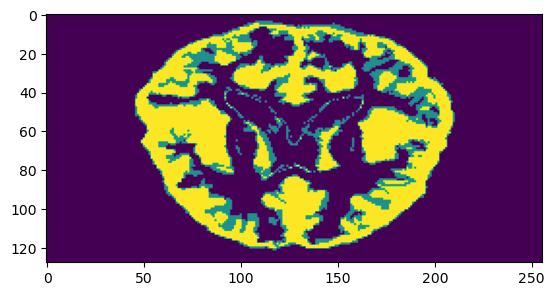

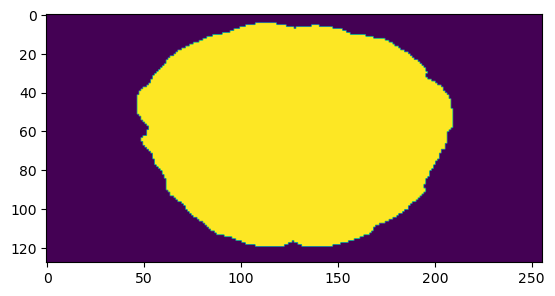

In [39]:
plt.figure()
plt.imshow(prob_atlas[1][150])
plt.figure()
plt.imshow(mask[150])